In [1]:
import librosa
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import DataLoader, Dataset

from pydub import AudioSegment
import soundfile as sf

import matplotlib.pyplot as plt
import librosa.display
import random
import torchaudio

import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T
import os
from tqdm import tqdm
import torch.cuda.amp as amp

In [2]:
def mu_law_encode(x, mu=255):
    """x: FloatTensor in [-1, 1] → returns LongTensor in [0, mu]"""
    mu = float(mu)
    safe_x = torch.clamp(x, -1.0, 1.0)
    x_mu = (
        torch.sign(safe_x)
        * torch.log1p(mu * torch.abs(safe_x))
        / torch.log1p(torch.tensor(mu, device=x.device))
    )
    encoded = ((x_mu + 1) / 2 * mu).round().clamp(0, mu).long()
    return encoded


def mu_law_decode(encoded, mu=255):
    """encoded: LongTensor in [0, mu] → returns FloatTensor in [-1, 1]"""
    mu = float(mu)
    x = encoded.float() / mu * 2 - 1
    decoded = torch.sign(x) * (1 / mu) * ((1 + mu) ** torch.abs(x) - 1)
    return decoded

In [3]:
class RawWaveformDataset(Dataset):
    def __init__(
        self, wav_dir, sample_rate=16000, duration=4.0, preload=True, mu_law=True
    ):
        self.wav_paths = [
            os.path.join(wav_dir, f) for f in os.listdir(wav_dir) if f.endswith(".wav")
        ]
        self.sample_rate = sample_rate
        self.duration = duration
        self.num_samples = int(duration * sample_rate)
        self.preload = preload
        self.mu_law = mu_law

        if self.preload:
            print(f"🔁 Preloading {len(self.wav_paths)} audio files...")
            self.cache = []
            for path in self.wav_paths:
                sample = self.process_file(path)
                if sample is not None:
                    self.cache.append(sample)
                else:
                    print(f"⚠️ Skipping bad/silent file: {path}")
            print(f"✅ Loaded {len(self.cache)} valid samples.")

    def __len__(self):
        return len(self.cache) if self.preload else len(self.wav_paths)

    def __getitem__(self, idx):
        while True:
            try:
                if self.preload:
                    return self.cache[idx]
                else:
                    sample = self.process_file(self.wav_paths[idx])
                    if sample is not None:
                        return sample
            except:
                idx = random.randint(0, len(self) - 1)

    def process_file(self, path):
        try:
            wav, sr = torchaudio.load(path)
            wav = wav.mean(dim=0)  # mono

            if sr != self.sample_rate:
                wav = torchaudio.functional.resample(
                    wav, orig_freq=sr, new_freq=self.sample_rate
                )

            # Pad or crop
            if wav.size(0) < self.num_samples:
                wav = F.pad(wav, (0, self.num_samples - wav.size(0)))
            elif wav.size(0) > self.num_samples:
                start = random.randint(0, wav.size(0) - self.num_samples)
                wav = wav[start : start + self.num_samples]

            # Normalize
            max_val = wav.abs().max()
            if max_val < 1e-6:
                return None  # skip flat files
            wav = wav / max_val

            raw_waveform = wav.unsqueeze(0)  # (1, T)
            if self.mu_law:
                encoded = mu_law_encode(raw_waveform).squeeze(0).long()  # (T,)
                return encoded, raw_waveform
            else:
                return raw_waveform

        except Exception as e:
            print(f"❌ Error loading file {path}: {e}")
            return None
        
    def get_raw(self, idx):
        """Returns raw waveform (FloatTensor) in [-1, 1] for generation use"""
        path = self.wav_paths[idx]
        wav, sr = torchaudio.load(path)
        wav = wav.mean(dim=0)  # mono

        if sr != self.sample_rate:
            wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=self.sample_rate)

        # Pad or crop
        if wav.size(0) < self.num_samples:
            wav = F.pad(wav, (0, self.num_samples - wav.size(0)))
        elif wav.size(0) > self.num_samples:
            start = random.randint(0, wav.size(0) - self.num_samples)
            wav = wav[start:start + self.num_samples]

        # Normalize safely
        max_val = wav.abs().max()
        if max_val > 0:
            wav = wav / max_val
        else:
            wav = torch.zeros_like(wav)

        return wav  # shape: (T,)


In [4]:
def compute_receptive_field(layers_per_cycle, dilation_cycles, kernel_size=2):
    return sum([(kernel_size - 1) * (2 ** i) for i in range(layers_per_cycle)] * dilation_cycles) + 1

class ResidualBlock(nn.Module):
    def __init__(self, residual_channels, skip_channels, dilation):
        super().__init__()
        self.dilation = dilation
        self.filter_conv = nn.Conv1d(
            residual_channels,
            residual_channels,
            kernel_size=2,
            dilation=dilation,
            padding=0,
        )
        self.gate_conv = nn.Conv1d(
            residual_channels,
            residual_channels,
            kernel_size=2,
            dilation=dilation,
            padding=0,
        )
        self.res_conv = nn.Conv1d(residual_channels, residual_channels, kernel_size=1)
        self.skip_conv = nn.Conv1d(residual_channels, skip_channels, kernel_size=1)

    def forward(self, x):
        pad = self.dilation
        x_padded = F.pad(x, (pad, 0))  # left-causal padding

        filter_out = torch.tanh(self.filter_conv(x_padded))
        gate_out = torch.sigmoid(self.gate_conv(x_padded))
        out = filter_out * gate_out

        res = self.res_conv(out)
        skip = self.skip_conv(out)
        return x + res, skip  # residual connection


class WaveNet(nn.Module):
    def __init__(
        self,
        in_channels=256,
        residual_channels=64,
        skip_channels=128,
        dilation_cycles=2,
        layers_per_cycle=10,
        embed_dim=64
    ):
        super().__init__()
        self.receptive_field = self.compute_receptive_field(
            layers_per_cycle=layers_per_cycle,
            dilation_cycles=dilation_cycles,
            kernel_size=2,  # you use kernel_size=2 in ResidualBlock
        )
        self.embedding = nn.Embedding(in_channels, embed_dim)
        self.input_proj = nn.Conv1d(embed_dim, residual_channels, kernel_size=1)
        self.res_blocks = nn.ModuleList()

        for cycle in range(dilation_cycles):
            for layer in range(layers_per_cycle):
                dilation = 2**layer
                self.res_blocks.append(
                    ResidualBlock(residual_channels, skip_channels, dilation)
                )

        self.output = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(skip_channels, skip_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(skip_channels, in_channels, kernel_size=1),  # final logits
        )

    def forward(self, x):  # x: (B, 256, T)
        x = self.embedding(x)         # (B, T, D)
        x = x.permute(0, 2, 1)        # (B, D, T)
        x = self.input_proj(x)        # (B, residual_channels, T)
        skip_total = []

        for block in self.res_blocks:
            x, skip = block(x)
            skip_total.append(skip)

        skip_sum = sum(skip_total)
        out = self.output(skip_sum)
        return out  # shape: (B, 256, T)
    
    @staticmethod
    def compute_receptive_field(layers_per_cycle, dilation_cycles, kernel_size=2):
        return sum([(kernel_size - 1) * (2 ** i) for i in range(layers_per_cycle)] * dilation_cycles) + 1


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")

# Initialize dataset
dataset = RawWaveformDataset(
    wav_dir="data", 
    sample_rate=16000,
    duration=3.0,
    preload=True,
    mu_law=True
)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=32, pin_memory=False)

🖥️ Using device: cuda
🔁 Preloading 1000 audio files...
✅ Loaded 1000 valid samples.


In [6]:
def visualize_reconstruction_live(model, waveform, step, sample_rate=16000):
    model.eval()
    with torch.no_grad():
        waveform = waveform.unsqueeze(0).to(model.embedding.weight.device)  # (1, T)
        print("Original waveform stats:")
        print(" → min:", waveform.min().item())
        print(" → max:", waveform.max().item())
        print(" → mean:", waveform.mean().item())
        print(" → std:", waveform.std().item())

        # Encode input
        x = mu_law_encode(waveform).long()
        x_input = x[:, :-1]  # (B, T-1)
        x_target = x[:, 1:]

        # Predict and decode
        y_pred = model(x_input)  # (B, 256, T-1)
        y_class = torch.argmax(y_pred, dim=1)  # (B, T-1)
        decoded = mu_law_decode(y_class.squeeze(0).cpu().detach())  # (T-1,)

    # Decode original for fair comparison
    original_decoded = mu_law_decode(mu_law_encode(waveform.squeeze(0).cpu()))
    original_decoded = original_decoded[: decoded.size(0)]  # match length

    # Plot waveform
    plt.figure(figsize=(12, 4))
    plt.plot(original_decoded[:1000], label="Original", alpha=0.7)
    plt.plot(decoded[:1000], label="Decoded", alpha=0.7)
    plt.title(f"Waveform Comparison @ Step {step}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot Mel spectrograms
    spec_transform = T.MelSpectrogram(
        sample_rate=sample_rate, n_fft=1024, hop_length=256, n_mels=80
    )
    original_spec = spec_transform(original_decoded.unsqueeze(0))[0]
    decoded_spec = spec_transform(decoded.unsqueeze(0))[0]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_spec.log2().numpy(), origin="lower", aspect="auto")
    plt.title("Original Mel")

    plt.subplot(1, 2, 2)
    plt.imshow(decoded_spec.log2().numpy(), origin="lower", aspect="auto")
    plt.title("Decoded Mel")

    plt.suptitle(f"Mel Spectrogram @ Step {step}")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_296572/1390292487.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Training:   0%|          | 0/100000 [00:00<?, ?it/s]/tmp/ipykernel_296572/1390292487.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Epoch 10 | Step 5000:   5%|▌         | 5000/100000 [27:26<8:40:46,  3.04it/s, gpu=60.7 MB, loss=3.7417] 

[Epoch 10 | Step 5000] Loss: 3.7417 | CUDA: 60.7 MB


Epoch 20 | Step 10000:  10%|█         | 10000/100000 [54:50<8:13:23,  3.04it/s, gpu=60.7 MB, loss=2.8862]

[Epoch 20 | Step 10000] Loss: 2.8862 | CUDA: 60.7 MB


Epoch 30 | Step 15000:  15%|█▌        | 15000/100000 [1:22:12<7:41:10,  3.07it/s, gpu=60.7 MB, loss=4.0678] 

[Epoch 30 | Step 15000] Loss: 4.0678 | CUDA: 60.7 MB


Epoch 40 | Step 20000:  20%|██        | 20000/100000 [1:49:34<7:13:51,  3.07it/s, gpu=60.7 MB, loss=3.3947] 

[Epoch 40 | Step 20000] Loss: 3.3947 | CUDA: 60.7 MB


Epoch 50 | Step 25000:  25%|██▌       | 25000/100000 [2:17:03<6:49:35,  3.05it/s, gpu=60.7 MB, loss=2.5792] 

[Epoch 50 | Step 25000] Loss: 2.5792 | CUDA: 60.7 MB


Epoch 60 | Step 30000:  30%|███       | 30000/100000 [2:44:29<6:23:17,  3.04it/s, gpu=60.7 MB, loss=2.9004] 

[Epoch 60 | Step 30000] Loss: 2.9004 | CUDA: 60.7 MB


Epoch 70 | Step 35000:  35%|███▌      | 35000/100000 [3:11:53<5:54:50,  3.05it/s, gpu=60.7 MB, loss=2.3439] 

[Epoch 70 | Step 35000] Loss: 2.3439 | CUDA: 60.7 MB


Epoch 80 | Step 40000:  40%|████      | 40000/100000 [3:39:26<5:25:39,  3.07it/s, gpu=60.7 MB, loss=2.1551] 

[Epoch 80 | Step 40000] Loss: 2.1551 | CUDA: 60.7 MB


Epoch 90 | Step 45000:  45%|████▌     | 45000/100000 [4:06:48<4:59:13,  3.06it/s, gpu=60.7 MB, loss=2.9609] 

[Epoch 90 | Step 45000] Loss: 2.9609 | CUDA: 60.7 MB


Epoch 100 | Step 50000:  50%|█████     | 50000/100000 [4:34:12<4:31:26,  3.07it/s, gpu=60.7 MB, loss=3.7047] 

[Epoch 100 | Step 50000] Loss: 3.7047 | CUDA: 60.7 MB
Original waveform stats:
 → min: -1.0
 → max: 0.8175248503684998
 → mean: 0.0005925173754803836
 → std: 0.11863948404788971


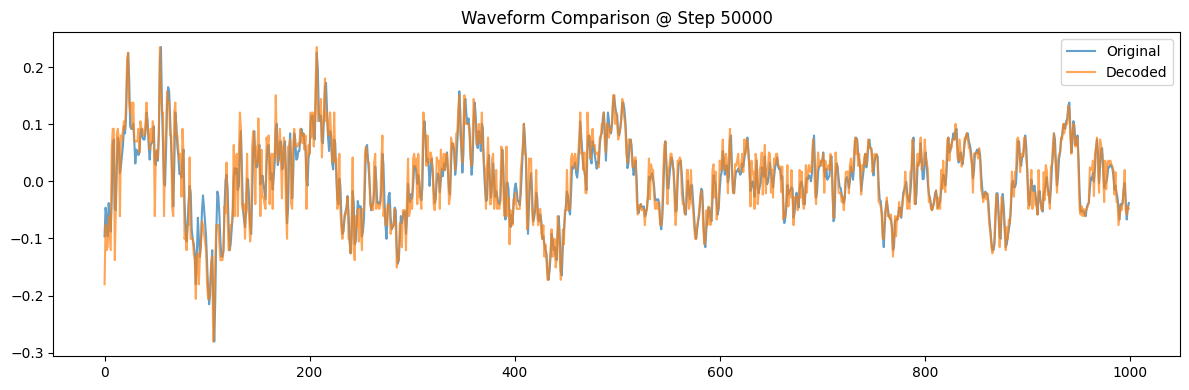

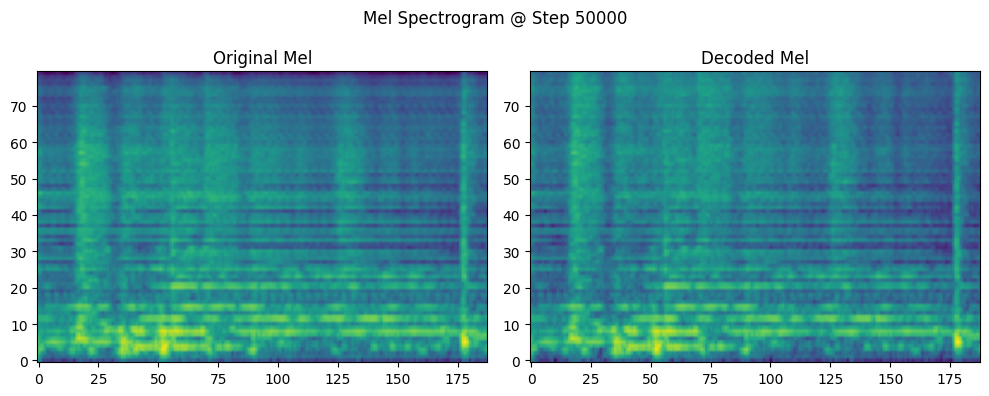

Epoch 110 | Step 55000:  55%|█████▌    | 55000/100000 [5:01:38<4:04:11,  3.07it/s, gpu=60.7 MB, loss=2.3208] 

[Epoch 110 | Step 55000] Loss: 2.3208 | CUDA: 60.7 MB


Epoch 120 | Step 60000:  60%|██████    | 60000/100000 [5:29:05<3:37:31,  3.06it/s, gpu=60.7 MB, loss=3.2392] 

[Epoch 120 | Step 60000] Loss: 3.2392 | CUDA: 60.7 MB


Epoch 130 | Step 65000:  65%|██████▌   | 65000/100000 [5:56:30<3:10:07,  3.07it/s, gpu=60.7 MB, loss=3.1924]

[Epoch 130 | Step 65000] Loss: 3.1924 | CUDA: 60.7 MB


Epoch 140 | Step 70000:  70%|███████   | 70000/100000 [6:23:55<2:42:59,  3.07it/s, gpu=60.7 MB, loss=2.5081]

[Epoch 140 | Step 70000] Loss: 2.5081 | CUDA: 60.7 MB


Epoch 150 | Step 75000:  75%|███████▌  | 75000/100000 [6:51:19<2:15:32,  3.07it/s, gpu=60.7 MB, loss=3.3494]

[Epoch 150 | Step 75000] Loss: 3.3494 | CUDA: 60.7 MB


Epoch 160 | Step 80000:  80%|████████  | 80000/100000 [7:18:42<1:48:32,  3.07it/s, gpu=60.7 MB, loss=3.3656]

[Epoch 160 | Step 80000] Loss: 3.3656 | CUDA: 60.7 MB


Epoch 170 | Step 85000:  85%|████████▌ | 85000/100000 [7:46:04<1:21:29,  3.07it/s, gpu=60.7 MB, loss=3.6497]

[Epoch 170 | Step 85000] Loss: 3.6497 | CUDA: 60.7 MB


Epoch 180 | Step 90000:  90%|█████████ | 90000/100000 [8:13:26<54:14,  3.07it/s, gpu=60.7 MB, loss=1.9984]  

[Epoch 180 | Step 90000] Loss: 1.9984 | CUDA: 60.7 MB


Epoch 190 | Step 95000:  95%|█████████▌| 95000/100000 [8:40:48<27:10,  3.07it/s, gpu=60.7 MB, loss=2.8606]  

[Epoch 190 | Step 95000] Loss: 2.8606 | CUDA: 60.7 MB


Epoch 200 | Step 100000: 100%|██████████| 100000/100000 [9:08:09<00:00,  3.07it/s, gpu=60.7 MB, loss=3.5563]

[Epoch 200 | Step 100000] Loss: 3.5563 | CUDA: 60.7 MB
Original waveform stats:
 → min: -0.939393937587738
 → max: 1.0
 → mean: 0.03442992642521858
 → std: 0.17902973294258118


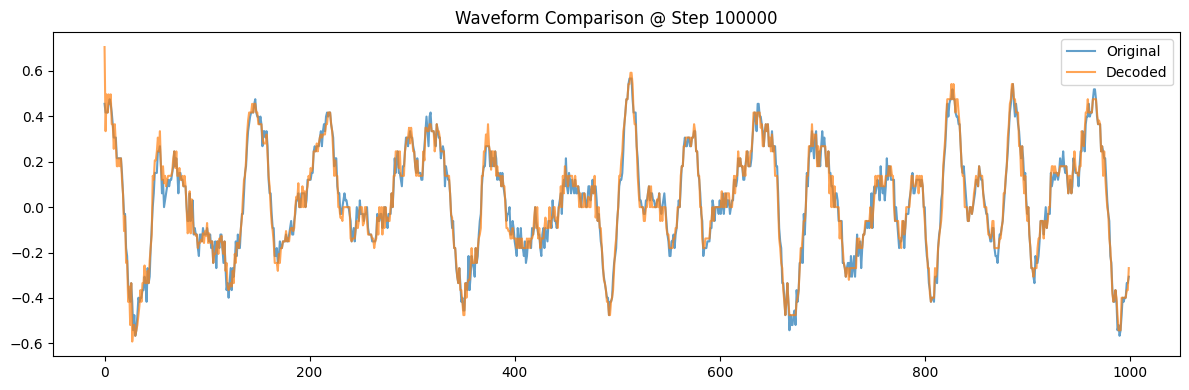

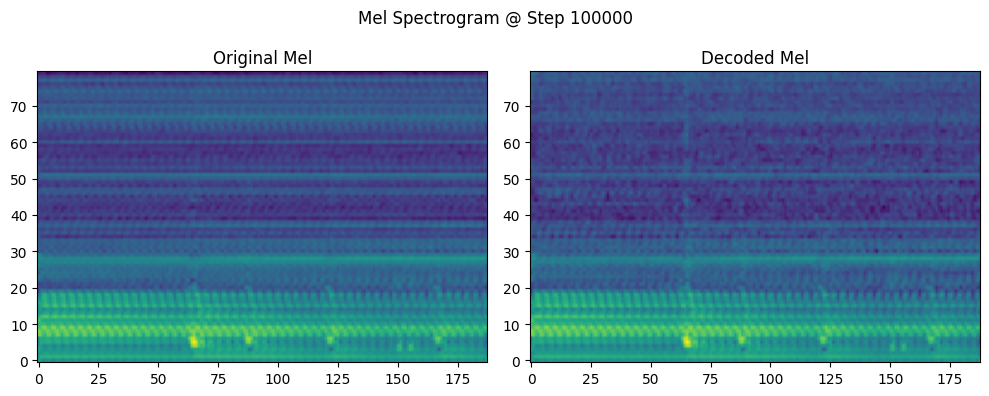

Epoch 200 | Step 100000: 100%|██████████| 100000/100000 [9:08:10<00:00,  3.04it/s, gpu=60.7 MB, loss=3.5563]


✅ Max steps 100000 reached.


In [7]:
model = WaveNet().to(device)
model.receptive_field = compute_receptive_field(
    layers_per_cycle=8, dilation_cycles=2, kernel_size=2
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = amp.GradScaler()

num_epochs = 200
max_steps = 100_000
step = 1
best_loss = float("inf")

pbar = tqdm(total=max_steps, desc="Training", dynamic_ncols=True)
os.makedirs("checkpoints", exist_ok=True)

for epoch in range(1, num_epochs + 1):
    for x, waveform in dataloader:
        if step > max_steps:
            break

        x = x.to(device)
        waveform = waveform.to(device)
        x_input = x[:, :-1]
        x_target = x[:, 1:]

        optimizer.zero_grad()

        with amp.autocast():
            y_pred = model(x_input)
            loss = F.cross_entropy(y_pred, x_target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        pbar.update(1)
        pbar.set_description(f"Epoch {epoch} | Step {step}")
        pbar.set_postfix(
            loss=f"{loss.item():.4f}",
            gpu=f"{torch.cuda.memory_allocated() / 1e6:.1f} MB",
        )

        if step % 5000 == 0:
            print(
                f"[Epoch {epoch} | Step {step}] Loss: {loss.item():.4f} | CUDA: {torch.cuda.memory_allocated() / 1e6:.1f} MB"
            )

        # --- Checkpoints ---
        # --- Best model ---
        if loss.item() < best_loss and step % 50000 == 0:
            best_loss = loss.item()
            torch.save(model.state_dict(), "checkpoints/best_model.pt")

        if step % 10000 == 0:
            torch.save(model.state_dict(), f"checkpoints/model_step{step}.pt")

        if step % 50000 == 0:
            sample_encoded, sample_wave = dataset[random.randint(0, len(dataset) - 1)]
            visualize_reconstruction_live(model, sample_wave.squeeze(0), step)

        step += 1

    if step > max_steps:
        print(f"\n✅ Max steps {max_steps} reached.")
        break

pbar.close()

In [8]:
def top_k_logits(logits, k=30):
    """Apply top-k filtering to logits."""
    topk_vals, _ = torch.topk(logits, k)
    min_topk = topk_vals[:, -1].unsqueeze(-1)
    return torch.where(
        logits < min_topk, torch.full_like(logits, float("-inf")), logits
    )


def generate(model, seed, steps=16000, temperature=1.0, top_k=None):
    """
    Generate waveform from a WaveNet model using mu-law tokens.

    Args:
        model: WaveNet model
        seed: FloatTensor in [-1, 1], shape (T,)
        steps: number of steps to generate
        temperature: sampling temperature (default 1.0)
        top_k: optional top-k sampling

    Returns:
        decoded waveform as FloatTensor (1D)
    """
    model.eval()
    device = next(model.parameters()).device

    # Encode seed to mu-law tokens
    x = mu_law_encode(seed).long().to(device).unsqueeze(0)  # (1, T)

    # Pad if seed is shorter than receptive field
    if x.size(1) < model.receptive_field:
        pad = model.receptive_field - x.size(1)
        x = F.pad(x, (pad, 0), value=127)  # pad with middle token

    output = x.squeeze(0).tolist()

    with torch.no_grad():
        for _ in range(steps):
            x_input = x[:, -model.receptive_field :]  # (1, T')
            y = model(x_input)  # (1, 256, T')
            logits = y[:, :, -1]  # (1, 256)

            # Apply temperature and optional top-k
            logits = logits / temperature
            if top_k:
                logits = top_k_logits(logits, k=top_k)

            probs = F.softmax(logits, dim=-1)  # (1, 256)
            sample = torch.multinomial(probs, num_samples=1)  # (1, 1)
            token = sample.item()
            output.append(token)

            # Update x with new sample
            x = torch.cat([x, sample], dim=1)

    # Decode mu-law tokens to waveform
    output_tensor = torch.tensor(output, dtype=torch.long)
    return mu_law_decode(output_tensor.cpu())  # FloatTensor (T,)

In [9]:
seed_waveform = dataset.get_raw(0)
seed = seed_waveform[: model.receptive_field]

generated_wave = generate(model, seed, steps=960_000)
torchaudio.save("generated_1min.wav", generated_wave.unsqueeze(0), 16000)

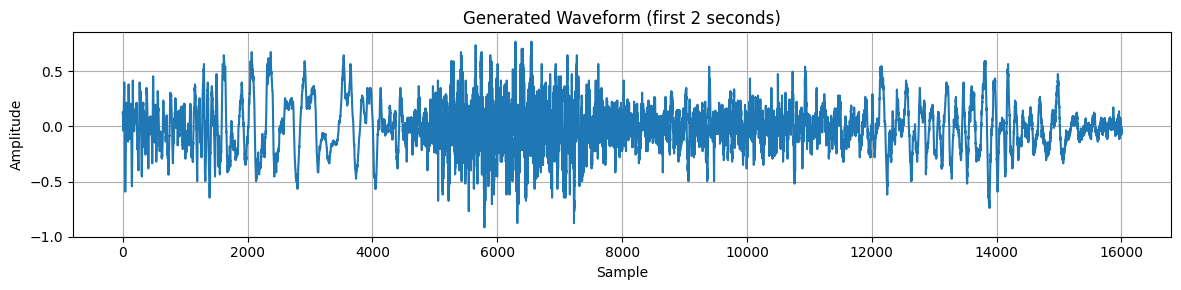

In [11]:
import torchaudio
import matplotlib.pyplot as plt

# Load the generated waveform
waveform, sr = torchaudio.load("generated_1min.wav")

# Plot first 2 seconds for readability
plt.figure(figsize=(12, 3))
plt.plot(waveform[0, : sr].cpu().numpy())
plt.title("Generated Waveform (first 2 seconds)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()